In [1]:
import osmnx as ox
# get the building footprints in Macclesfield
place = "Landkreis Breisgau-Hochschwarzwald"
place_abk='LKBH'
#tags = {'building': 'school'}
# Ebene Landkreis
tags = {'admin_level': '6'}
#gdf = ox.geometries_from_place(place, tags)

#tags = {'boundary': 'administrative'}   

bh_osmid='R1946367'
lk_bh=ox.geocode_to_gdf(bh_osmid, by_osmid=True)
lk_bh_poly=lk_bh.geometry[0]

<Axes: >

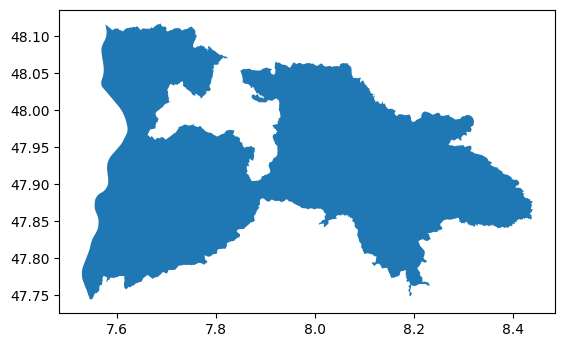

In [2]:
lk_bh.plot()

In [3]:
# Ebene Gemeinde
tags = {'admin_level': '8'}
gdf =ox.features.features_from_polygon(lk_bh_poly,tags)
in_bh=gdf.within(lk_bh_poly)
gem_in_bh_gdf=gdf[in_bh & (gdf['name'].notnull()) & (gdf['type'] == 'boundary') ]  

In [4]:
import json
with open('schulen.json') as f:
    x = json.load(f)

In [5]:
# Ebene Ortsteile
#in_bh_gdf.plot()
tags = {'boundary': 'administrative'}
orte_bh_gdf =ox.features.features_from_polygon(lk_bh_poly,tags)
in_bh=orte_bh_gdf.within(lk_bh_poly)
ort_in_bh_gdf=orte_bh_gdf[in_bh & (orte_bh_gdf['name'].notnull()) & (orte_bh_gdf['type'] == 'boundary') & orte_bh_gdf['de:regionalschluessel'].isnull()] 


In [6]:
# Straßen in LK BH
network_type = "walk"
trip_times = [5, 10, 15, 20, 25,30,40,120]  # in minutes
travel_speed = 3  # walking speed in km/hour

# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0)

lk_bh_walk=ox.graph_from_polygon(lk_bh_poly,network_type=network_type)
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in lk_bh_walk.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

tags = {'addr:housenumber': True}
lk_build_hn=ox.features_from_polygon(lk_bh_poly,tags)

tags_lu={'landuse':True}
#         ['residential','farmyard','industrial','commercial']}
lk_flaeche_landuse=ox.features_from_polygon(lk_bh_poly,tags_lu)



In [ ]:
import networkx as nx
from shapely.geometry import Point
from matplotlib import pyplot as plt
import geopandas as gpd
from matplotlib.colors import to_rgba
import pandas as pd
import matplotlib        
br=1
anz=1

#br=2
#anz=25
#fig, axs = plt.subplots(anz,br,figsize=(30, 120))
#sw=0


cmap = matplotlib.cm.jet
norm = matplotlib.colors.BoundaryNorm(trip_times, cmap.N)

for index, row in gem_in_bh_gdf.iterrows():
    gem_name=row['name']
    if gem_name=='Merzhausen':
        poly_merzhausen=gpd.GeoSeries(row['geometry'])

anz_erg=0
for index, row in gem_in_bh_gdf.iterrows():
    gem_name=row['name']
    
    #if gem_name=='Ehrenkirchen' or gem_name=='Au':
    #if gem_name=='Heitersheim':
    if 1==1:
        node_colors = {}
        node_time = {}
        poly_gem_road = gpd.GeoSeries(row['geometry'])
        if gem_name=='Au':
            poly_gem_road=poly_gem_road.union(poly_merzhausen)
        roads=ox.truncate.truncate_graph_polygon(lk_bh_walk,poly_gem_road.any(), truncate_by_edge=True)
        
        sc=[]
        for cur in (x["schools"]):
            p=Point(cur["lng"],cur["lat"])
            if p.within(poly_gem_road).any(): 
                sc=sc+[[p,cur["name"]]]
                poi=ox.distance.nearest_nodes(roads, cur["lng"],cur["lat"])
                for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
                    subgraph = nx.ego_graph(roads, poi, radius=trip_time, distance="time")
                    rgba_color=to_rgba(color)
                    for node in subgraph.nodes():
                        col_time=10000000
                        if node in node_time:
                            col_time=node_time[node]
                        if trip_time<col_time:
                            node_time[node] = trip_time    
                        col_old=0
                        if node in node_colors:
                            col_old=sum(node_colors[node])
                        #try:
                        if sum(rgba_color)>col_old:
                            node_colors[node] = rgba_color
                        #except Exception as e:
                        #    print(color)
                        #    print(col_old)
        
   
                
        
        poly_gem_hn = gpd.GeoSeries(row['geometry'])
        poly_gem_hn_gdf=row['geometry']


        

        in_poly_gem_hn=lk_build_hn.within(poly_gem_hn_gdf)
        gem_in_hn_gdf=lk_build_hn[in_poly_gem_hn ]  

        in_poly_gem_landuse_ol=lk_flaeche_landuse.overlaps(poly_gem_hn_gdf)
        in_poly_gem_landuse_wi=lk_flaeche_landuse.within(poly_gem_hn_gdf)
        gem_landuse_gdf=lk_flaeche_landuse[in_poly_gem_landuse_ol | in_poly_gem_landuse_wi]  
        #gem_landuse_gdf=gem_landuse_gdf.append(lk_flaeche_landuse[in_poly_gem_landuse_wi])

        
        subplot=ox.distance.nearest_nodes(roads,gem_in_hn_gdf['geometry'].to_crs('EPSG:3857').centroid.to_crs('EPSG:4326').x,gem_in_hn_gdf['geometry'].to_crs('EPSG:3857').centroid.to_crs('EPSG:4326').y)

        #gem_in_hn_gdf['triptime']=200
        gem_in_hn_gdf.loc[gem_in_hn_gdf.index,['gem_name']]=gem_name
        gem_in_hn_gdf.loc[gem_in_hn_gdf.index,['landuse']]='unbekannt'
        gem_in_hn_gdf.loc[gem_in_hn_gdf.index,['ortsteil']]='kein Ortsteil'
        gem_in_hn_gdf.loc[gem_in_hn_gdf.index,['nearest_node']]=0
        gem_in_hn_gdf.loc[gem_in_hn_gdf.index,['nearest_node']]=subplot
        
        gem_in_hn_gdf=gem_in_hn_gdf.merge(pd.DataFrame(node_time.items(),columns=['node','triptime']),how='left',left_on='nearest_node', right_on='node')
        gem_in_hn_gdf=gem_in_hn_gdf.fillna({'triptime':120})

        for cur in gem_landuse_gdf['landuse'].unique():
            lu_speziell=gem_landuse_gdf[gem_landuse_gdf['landuse']==cur]
            st=0
            for index, row in lu_speziell.iterrows():
                if st==0:
                    poly_gem_lu=row['geometry']
                    st+=1
                else:
                    poly_gem_lu=poly_gem_lu.union(row['geometry'])
            in_hn_in_landuse=gem_in_hn_gdf.within(poly_gem_lu)
            gem_in_hn_gdf.loc[in_hn_in_landuse,['landuse']]=cur

        in_gem=ort_in_bh_gdf.within(poly_gem_hn_gdf)
        ort_in_gem=ort_in_bh_gdf[in_gem]
        for idx_ort, row_ort in ort_in_gem.iterrows():
            ort_poly=row_ort['geometry']            
            in_hn_in_ort=gem_in_hn_gdf.within(ort_poly)
            gem_in_hn_gdf.loc[in_hn_in_ort,['ortsteil']]=row_ort['name']

        #gem_in_hn_gdf=gem_in_hn_gdf[['triptime']].fillna(value=120)
        


        if anz_erg==0:
            all_hn=gem_in_hn_gdf
            anz_erg+=1
        else:
            
            all_hn=pd.concat([all_hn,gem_in_hn_gdf])


        gp_x=poly_gem_hn.bounds['maxx']-poly_gem_hn.bounds['minx']
        gp_y=poly_gem_hn.bounds['maxy']-poly_gem_hn.bounds['miny']
        md=max(gp_x[0],gp_y[0])
        size=60/md
        fig, axs = plt.subplots(anz,br,figsize=(int(gp_x*size), int(gp_y*size)))
        #fig, axs = plt.subplots(anz,br)
        axs.set_title(gem_name)

        gem_landuse_gdf[gem_landuse_gdf['landuse'].isin(['residential','commercial','farmyard','industrial'])].plot(ax=axs,column='landuse', facecolor='none',legend=True)


        for idx_orte, row_orte in ort_in_gem.iterrows():
            p_center=row_orte['geometry'].centroid
            poly_ort = gpd.GeoSeries(row_orte['geometry'])
            poly_ort.plot(ax=axs,facecolor='none', edgecolor='green')
            axs.annotate(text=row_orte["name"], xy=(p_center.x,p_center.y), horizontalalignment='center')
        poly_gem_hn.plot(ax=axs,facecolor='none', edgecolor='blue') 

        gem_in_hn_gdf.plot(ax=axs,column='triptime',markersize =5, cmap=cmap,norm=norm)
        #nc = [node_colors[node] if node in node_colors else "none" for node in gdf_gem_walk.nodes()]
        #ns = [5 if node in node_colors else 0 for node in gdf_gem_walk.nodes()]
        #poly_ort.plot(ax=axs,facecolor='none', edgecolor='green')
        fig, ax = ox.plot_graph(
            roads,
            ax=axs,
            #node_color=nc,
            #node_size=ns,
            node_alpha=0.8,
            edge_linewidth=0.2,
            edge_color="#999999",
            show=False, 
            close=False
        )
        for cur in sc:
            axs.scatter(cur[0].x,cur[0].y,color='red',s=80)    
            axs.annotate(text=cur[1], xy=(cur[0].x,cur[0].y), horizontalalignment='center')        

        plt.savefig('images/'+place_abk+'-'+gem_name+'.png')

erg=all_hn.groupby(['gem_name','ortsteil','landuse','triptime']).size().to_frame('size')
erg.to_csv(place_abk+'ausw_2025.csv')
            #poly_gem_road.plot()
#poly_gem_hn.plot()
#gem_landuse_gdf.plot()
#gem_in_hn_gdf.plot()

#nc = [node_colors[node] if node in node_colors else "none" for node in roads.nodes()]
#ns = [15 if node in node_colors else 0 for node in roads.nodes()]
#fig, ax = ox.plot_graph(
#    roads,
#    node_color=nc,
#    node_size=ns,
#    node_alpha=0.8,
#    edge_linewidth=0.2,
#    edge_color="#999999",
#    show=False, 
#    close=False
#)

In [ ]:
#gem_in_hn_gdf.groupby(['ortsteil','landuse','triptime']).size()
#gem_in_hn_gdf.groupby(['ortsteil','landuse','triptime']).size()
gp_x[0]

In [ ]:
gem_in_hn_gdf=gem_in_hn_gdf.fillna({'triptime_y':120})

In [ ]:
da=pd.concat([da,gem_in_hn_gdf])

In [117]:
erg

size
gem_name ortsteil      landuse     triptime      
Au       kein Ortsteil commercial  20.0         2
                       farmyard    25.0         1
                                   40.0         2
                                   120.0        3
                       residential 20.0         7
...                                           ...
Wittnau  kein Ortsteil residential 10.0       185
                                   15.0       109
                                   20.0        68
                                   120.0        1
                       unbekannt   25.0         1

[1860 rows x 1 columns]

In [ ]:
gem_landuse_gdf[gem_landuse_gdf['landuse']=='residential']

In [ ]:
erg3=erg2.add(gem_in_hn_gdf.groupby(['gem_name','ortsteil','landuse','triptime']).size().to_frame('size'))

In [ ]:
da.groupby(['gem_name','ortsteil','landuse','triptime']).size()

In [9]:
type(all_hn)

geopandas.geodataframe.GeoDataFrame

In [150]:
erg.save_csv(place_abk+'ausw_2025.csv')

AttributeError: 'DataFrame' object has no attribute 'save_csv'

In [22]:

gp_x=lk_bh.bounds['maxx']-lk_bh.bounds['minx']
gp_y=lk_bh.bounds['maxy']-lk_bh.bounds['miny']

/tmp/ipykernel_349576/2565387059.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  fig, axs = plt.subplots(figsize=(int(gp_x*size), int(gp_y*size)))


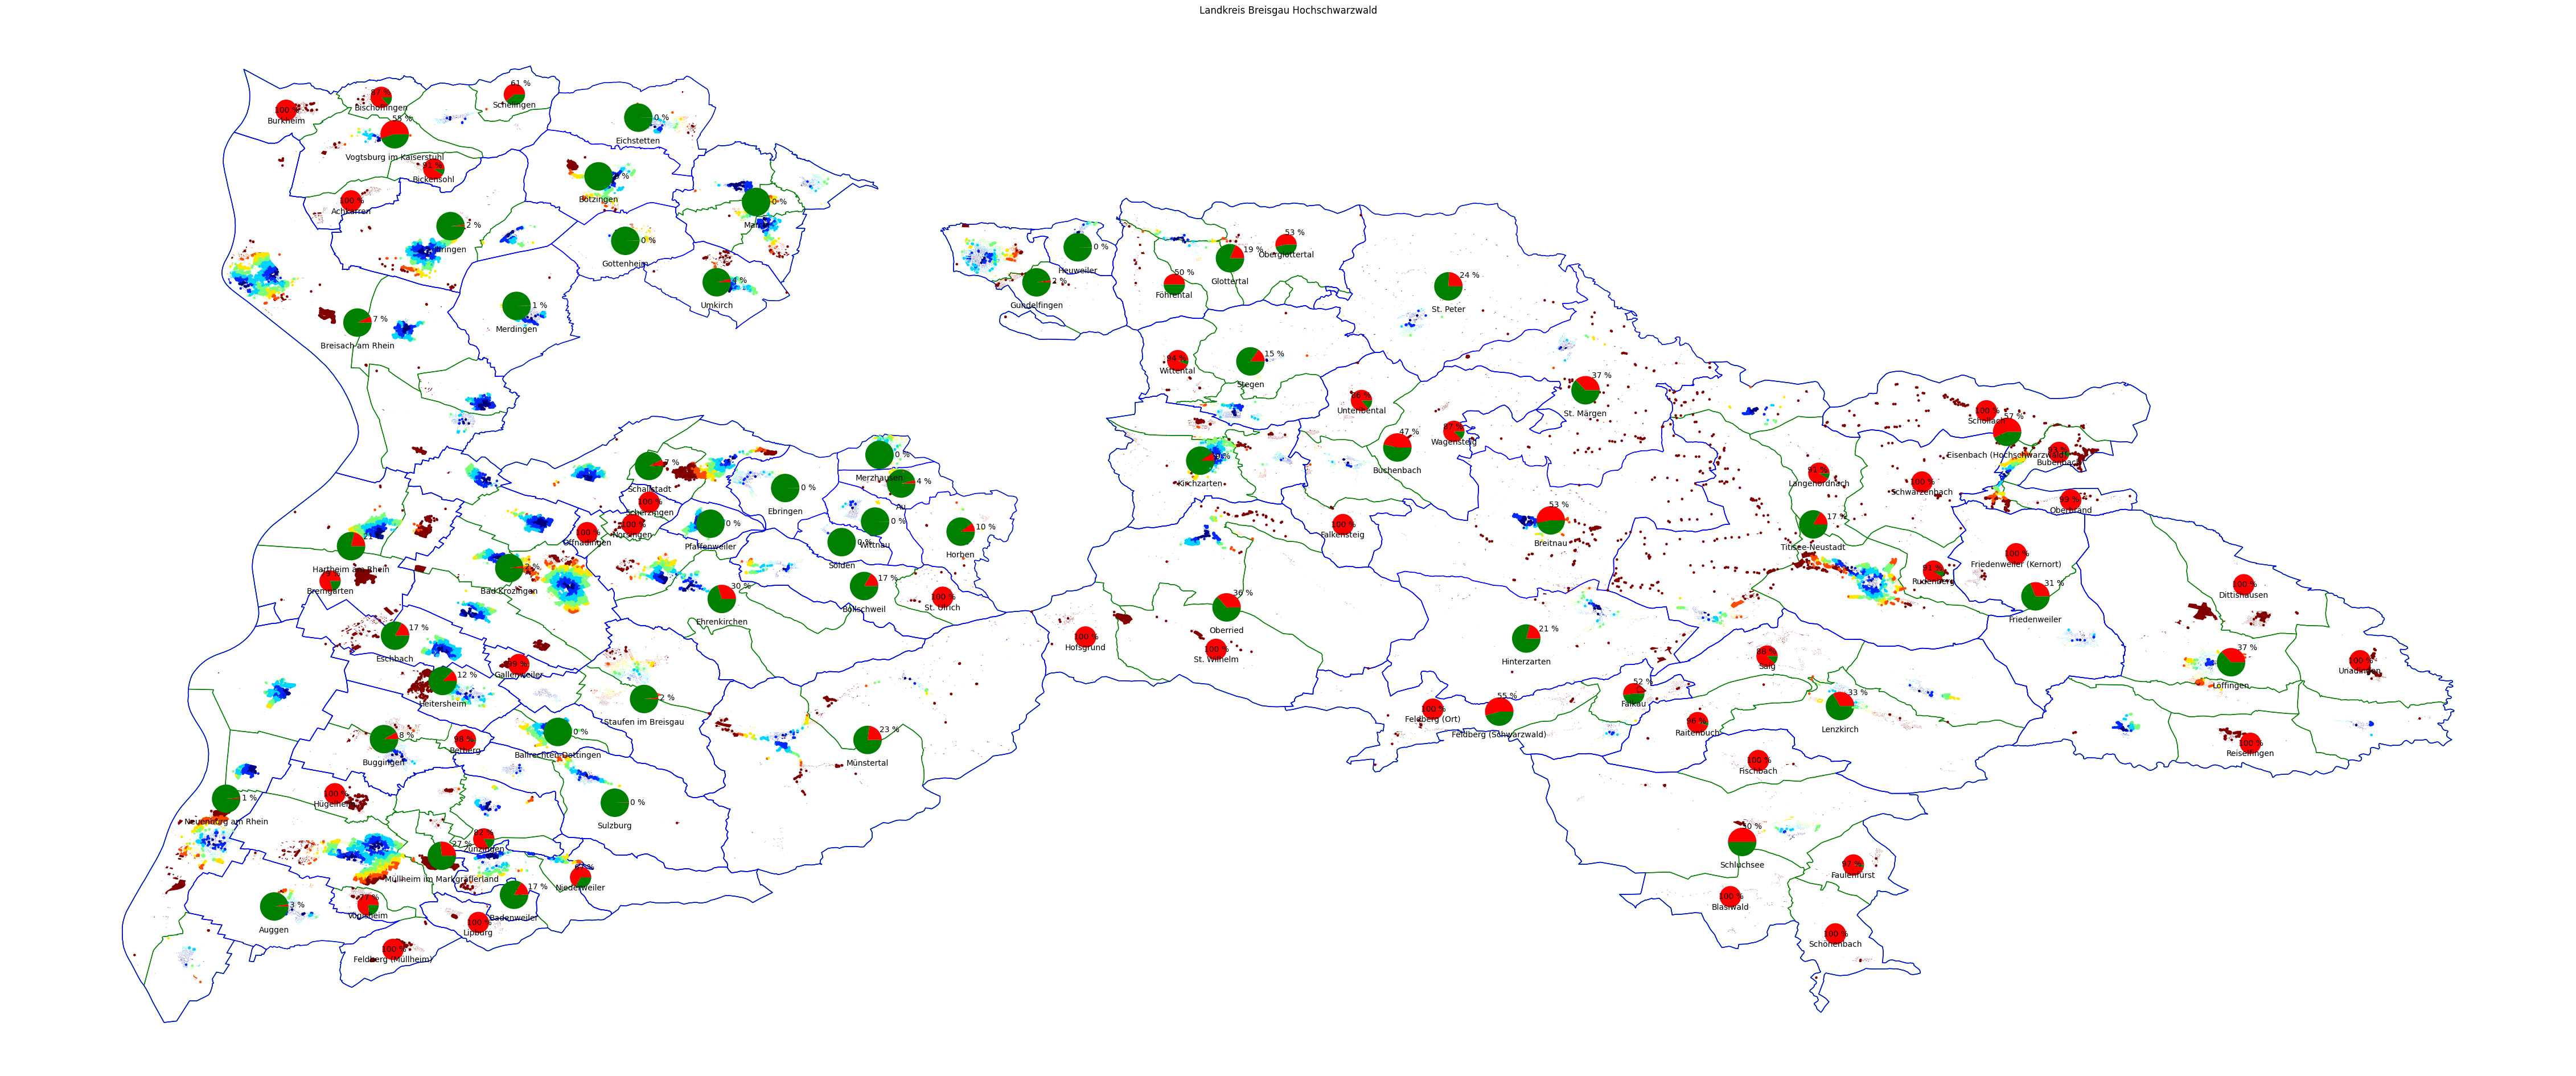

In [116]:
gp_x=lk_bh.bounds['maxx']-lk_bh.bounds['minx']
gp_y=lk_bh.bounds['maxy']-lk_bh.bounds['miny']
md=max(gp_x[0],gp_y[0])
size=60/md
fig, axs = plt.subplots(figsize=(int(gp_x*size), int(gp_y*size)))
axs.set_title('Landkreis Breisgau Hochschwarzwald')
lk_bh.plot(ax=axs,facecolor='none', edgecolor='green')
#lk_flaeche_landuse[lk_flaeche_landuse['landuse'].isin(['commercial','farmyard','industrial'])].plot(ax=axs,column='landuse', facecolor='none',legend=True)
ort_in_bh_gdf.plot(ax=axs,facecolor='none', edgecolor='green')
gem_in_bh_gdf.plot(ax=axs,facecolor='none', edgecolor='blue')
all_hn.plot(ax=axs,column='triptime',markersize =5, cmap=cmap,norm=norm)
y_init = axs.get_ylim()
x_init = axs.get_xlim()
for index, row in gem_in_bh_gdf.iterrows():
    gem_name=row['name'] 
    res=sum(erg[erg.index.isin([gem_name], level=0) & erg.index.isin([120.0], level=3)]['size'])/sum(erg[erg.index.isin([gem_name], level=0)]['size'])
    pos=row['geometry']
    sizes=[res,1-res]
    labels=['{} %'.format(round(res*100)),""]
    color_map = ['red', 'green']
    #print(gem_name,res,row['name'],pos.centroid.x,  )
    axs.pie(sizes,center=(pos.centroid.x,pos.centroid.y),radius=1/180, colors=color_map,labels=labels)
    axs.annotate(text=gem_name, xy=(pos.centroid.x,pos.centroid.y-0.01), horizontalalignment='center')

for index, row in ort_in_bh_gdf.iterrows():
    gem_name=row['name'] 
    res=sum(erg[erg.index.isin([gem_name], level=1) & erg.index.isin([120.0], level=3)]['size'])/sum(erg[erg.index.isin([gem_name], level=1)]['size'])
    pos=row['geometry']
    sizes=[res,1-res]
    labels=['{} %'.format(round(res*100)),""]
    color_map = ['red', 'green']
    #print(gem_name,res,row['name'],pos.centroid.x,  )
    if res > 0.4:
        axs.pie(sizes,center=(pos.centroid.x,pos.centroid.y),radius=1/240, colors=color_map,labels=labels)
        axs.annotate(text=gem_name, xy=(pos.centroid.x,pos.centroid.y-0.005), horizontalalignment='center')


#_ = axs.yaxis.set_ticks(range(0, round(y_init[1])+10, 10))
#_ = axs.xaxis.set_ticks(range(0, round(x_init[1])+10, 10))  
axs.set_ylim(y_init)
axs.set_xlim(x_init)
plt.savefig('images/'+place_abk+'- gesamt.png')
plt.show()


In [98]:
dir(axs)

['ArtistList',
 '_AxesBase__clear',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autotitlepos',
 '_axes',
 '_axes_locator',
 '_axis_map',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_different_canvas',
 '_errorevery_to_mask',
 '_facecolor',
 '_fill_between_x_or_y',
 '_forward_navigation_events',
 '_frameon',
 '_fully_clipped_to_axes',
 '_gci',
 '_gen

In [62]:
trip_times = [5, 10, 15, 20, 25,30,40,120]  # in minutes
cmap = matplotlib.cm.jet
norm = matplotlib.colors.BoundaryNorm(trip_times, cmap.N)

In [60]:
sum(erg[erg.index.isin(['Ehrenkirchen'], level=0) & erg.index.isin([120.0], level=3)]['size'])/sum(erg[erg.index.isin(['Ehrenkirchen'], level=0)]['size'])

0.2970443349753695

In [111]:
print('{} %'.format(round(9.123)))

9 %


Bötzingen 0.0 Bötzingen 7.7157406337868375 48.07382990495439
Eichstetten 0.0031023784901758012 Eichstetten 7.731265838465415 48.09673386328426
Breisach am Rhein 0.07068452380952381 Breisach am Rhein 7.621601457134655 48.01673849850299
Ihringen 0.017987633501967398 Ihringen 7.6579456268907355 48.05437841564728
Vogtsburg im Kaiserstuhl 0.5460271317829457 Vogtsburg im Kaiserstuhl 7.636120677186024 48.0902479718762
Merdingen 0.005291005291005291 Merdingen 7.683725176934691 48.023253555488914
Heuweiler 0.0033003300330033004 Heuweiler 7.902822075313039 48.0461177148921
Glottertal 0.1851400730816078 Glottertal 7.962256086662709 48.04186689074978
Münstertal 0.22826086956521738 Münstertal 7.820747988099959 47.853799894845324
Oberried 0.36387434554973824 Oberried 7.960923123269673 47.905539918827785
Stegen 0.1522359657469077 Stegen 7.970226401183139 48.001585058263345
Staufen im Breisgau 0.018777082330284064 Staufen im Breisgau 7.733518502159337 47.86978445759113
Neuenburg am Rhein 0.01378254211